# Main CNN model for bat call classification

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Callable
import tensorflow as tf
print(tf.__version__)
# to diable tensorflow-metal/GPU; testzwecke
tf.config.set_visible_devices([], 'GPU')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow_addons.metrics import F1Score
import math
import pickle
import cv2
import time
from sklearn.model_selection import train_test_split
import itertools_len as itertools
from itertools_len import product
import gc

2.15.0


/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# memory optimization, see https://github.com/tensorflow/tensorflow/issues/31312#issuecomment-813944860
class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()
#        tf.reset_default_graph()
        gc.collect()

def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    #config = tf.compat.v1.ConfigProto()
    #config.gpu_options.per_process_gpu_memory_fraction = 1
    #config.gpu_options.visible_device_list = "0"
    #tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [3]:
# class to track execution time of certain code events
class track_time:
    def __init__(self):
        self.events = []
        self.add('Start')
    def add(self, name: str) -> None:
        if name == "total":
            raise RuntimeError("Cant use the name 'total'.")
        self.events.append([name,time.time()])
    def get_time(self): # calculate time between events and total
        self.timed_events = {}
        for (n, event) in enumerate(self.events):
            elapsed_time = 0
            if n+1 == len(self.events):
                # last element
                elapsed_time = time.time() - event[1]
            else:
                elapsed_time = self.events[n+1][1] - event[1]
            self.timed_events[event[0]] = elapsed_time
        self.timed_events['total'] = time.time() - self.events[0][1]
        return self.timed_events
    def __str__(self):
        output = ""
        if not hasattr(self,'timed_events'):
            self.get_time()
        output += ("  Event tracked  |  Duration  \n")
        output += ("==============================\n")
        for name,duration in self.timed_events.items():
            output += (" "+name+"\t\t\t| "+str(round(duration,3))+"\n")
        return output

In [16]:
# timer
timer = track_time()
timer.add("Read in data")
# load image data s and reshape 
data = pd.read_pickle('./data/images_df_numerical.pkl')

# convert to numpy array
X, y = data['data'], data['Species']
classes = y.unique()
print(classes)
image_size = X[0].size
samples = X.size
image_shape = (216,334,3) # height, width , channel
# reshape every row to the image, swap rgbs and scale to 0-1
X = [
    cv2.cvtColor(row.reshape(image_shape), cv2.COLOR_BGR2RGB).astype('float32')/255. 
    for row in X]
y = [row.astype('int32') for row in y]

Species
2    665
4    290
0    287
1    116
5    110
6     60
3      3
Name: count, dtype: int64
Species
2    665
4    290
0    287
1    116
5    110
6     60
Name: count, dtype: int64
                                                   data Species
0     [8, 2, 10, 22, 4, 21, 22, 4, 21, 22, 5, 24, 22...       0
1     [0, 0, 0, 0, 0, 0, 16, 2, 8, 6, 1, 1, 6, 1, 2,...       2
2     [7, 3, 12, 21, 6, 26, 20, 7, 30, 15, 2, 7, 18,...       4
3     [6, 0, 3, 22, 4, 20, 20, 7, 30, 18, 10, 36, 14...       2
4     [7, 0, 4, 21, 2, 16, 21, 6, 26, 21, 2, 16, 19,...       4
...                                                 ...     ...
1526  [8, 0, 5, 22, 4, 21, 22, 3, 18, 20, 8, 32, 22,...       5
1527  [6, 0, 3, 20, 2, 12, 14, 13, 41, 18, 10, 36, 1...       2
1528  [7, 0, 4, 2, 0, 0, 21, 6, 27, 21, 6, 26, 22, 3...       2
1529  [0, 0, 0, 21, 2, 15, 7, 1, 2, 18, 10, 36, 21, ...       0
1530  [8, 1, 8, 21, 2, 13, 19, 8, 32, 19, 1, 10, 13,...       2

[1528 rows x 2 columns]
[0 2 4 5 6 1]


In [17]:
timer.add("Split Train/Test")
# Cross Valiadation, wenn wir ein 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# conver to tensor for memory optimization
X_train = tf.convert_to_tensor(np.array(X_train))
y_train = tf.convert_to_tensor(np.array(y_train))

X_val = tf.convert_to_tensor(np.array(X_val))
y_val = tf.convert_to_tensor(np.array(y_val))

X_test = tf.convert_to_tensor(np.array(X_test))
y_test = tf.convert_to_tensor(np.array(y_test))

In [18]:
# hyperparameter
number_of_classes = classes.size
pooling_size = (2, 2)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
padding = "same"
epochs = 1
dropout_rate = 1 - 0.8 # ggf anpassen, wenn overfittet

def create_model(conv_kernel_sizes: list, conv_filter_nums: list, number_of_neurons: list, optimizer="adam", activation_function="relu"):
    f1 = F1Score(num_classes=number_of_classes, average="micro")

    model=Sequential()

    # adding activaation function seperate for memory optimization, 
    #   see https://github.com/tensorflow/tensorflow/issues/46475#issuecomment-817191096 and 
    #       https://github.com/tensorflow/tensorflow/issues/46475#issuecomment-1288677907
    
    model.add(Conv2D(conv_filter_nums[0], conv_kernel_sizes[0],activation=activation_function,input_shape=image_shape,padding=padding))
    #model.add(activation_function)
    # MaxPool2D((2, 2), strides=(2, 2), dtype="mixed_float16")(x)
    model.add(MaxPool2D(pooling_size, strides=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(conv_filter_nums[1],conv_kernel_sizes[1],activation=activation_function, padding=padding))
    #model.add(activation_function)
    model.add(MaxPool2D(pooling_size, strides=(2, 2)))
    model.add(Dropout(dropout_rate))

    # Classficiation
    model.add(Flatten())
    model.add(Dense(number_of_neurons[0], activation=activation_function))
    #model.add(activation_function)
    model.add(Dropout(dropout_rate))

    model.add(Dense(number_of_neurons[1], activation=activation_function))
    #model.add(activation_function)
    model.add(Dropout(dropout_rate))

    model.add(Dense(number_of_neurons[2], activation=activation_function))
    #model.add(activation_function)
    model.add(Dropout(dropout_rate))

    # Output-Layer
    model.add(Dense(number_of_classes, activation="softmax"))
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy", f1]) #,run_eagerly=True) # eagerly for memory optimization, see https://github.com/tensorflow/tensorflow/issues/31312#issuecomment-821809246

    tf.keras.backend.clear_session()
    #tf.compat.v1.reset_default_graph()
    gc.collect()
    return model
    

In [19]:
from tensorflow.keras.optimizers.legacy import Adam, SGD # using the legacy versions, cause M1/M2 chips run slower with the new one
from tensorflow.keras.optimizers.legacy import Adagrad
from tensorflow.keras.optimizers.schedules import ExponentialDecay

number_of_classes = classes.size
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
epochs = 200
dropout_rate = 0.4

def kaggle_model(optimizer):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=image_shape))
    model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(number_of_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

s = 130 * len(X_train) // 32 # number of steps in 130 epochs (batch size = 32)
exp_decay_sgd_adagrad = ExponentialDecay(0.01, s, 0.1)
exp_adam = ExponentialDecay(0.1, s, 0.95, staircase=True)

momentum = 0.99
sgd_exp = SGD(exp_decay_sgd_adagrad, momentum=momentum)
adam_exp = Adam(exp_adam)
adagrad_exp = Adagrad(exp_decay_sgd_adagrad)

sgd = SGD(0.001, momentum=momentum)
adam = Adam(0.001)
adagrad = Adagrad(0.001)

optimizers = {"sgd_exp": sgd_exp, "adam_exp": adam_exp, "adagrad_exp": adagrad_exp, "sgd": sgd, "adam": adam, "adagrad": adagrad}


histories_with_params = list()

for optimizer_name, optimizer in optimizers.items():
    model = None
    model = kaggle_model(optimizer)
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        workers=1, # workers are number of cores
        callbacks=early_stopping,
        validation_data=(X_val, y_val),
        verbose=1)
    model.save(f"cnn_files/model_{optimizer_name}.keras", overwrite=True)   # bitte einfach .keras nutzen, .h5 ist legacy
    history_with_param = {"optimizer": optimizer_name, "history": history}
    histories_with_params.append(history_with_param)

Epoch 1/200


2023-12-21 12:22:48.400702: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 6 which is outside the valid range of [0, 6).  Label values: 1 2 2 4 0 2 2 6 2 2 0 2 2 1 0 1 4 5 4 5 6 2 0 2 0 2 2 2 2 0 2 2


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1077, in launch_instance

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/g5/s1_7yy_x793463sh2_n7p8hh0000gn/T/ipykernel_13275/1902283321.py", line 59, in <module>

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/Users/seba/Documents/main_data_cloud/oth/s3/ml/.venv/lib/python3.11/site-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

Received a label value of 6 which is outside the valid range of [0, 6).  Label values: 1 2 2 4 0 2 2 6 2 2 0 2 2 1 0 1 4 5 4 5 6 2 0 2 0 2 2 2 2 0 2 2
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_6037]

10/10 [==============================] - 0s 21ms/step - loss: 1.0159 - accuracy: 0.5850


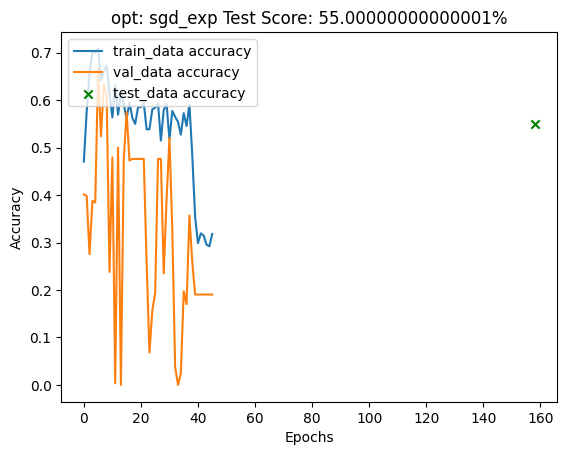

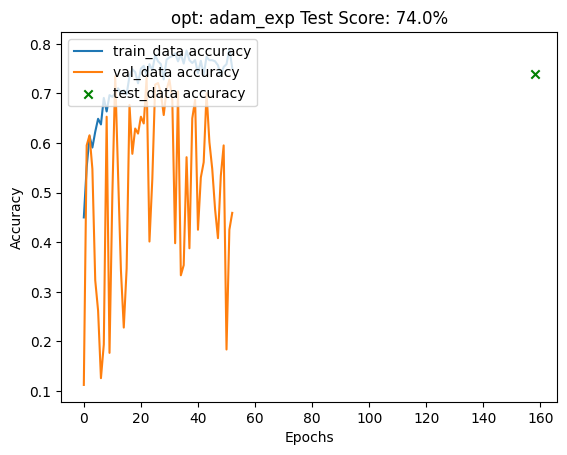

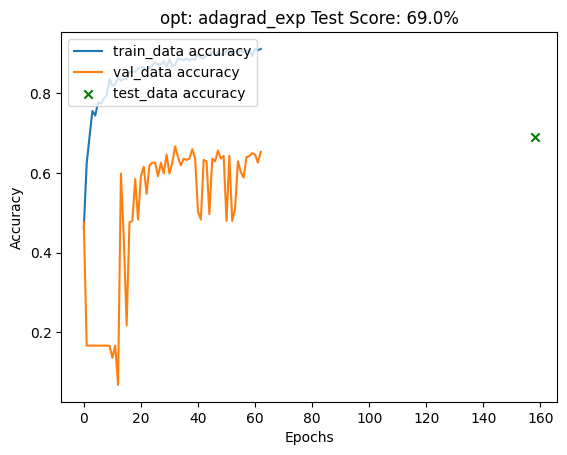

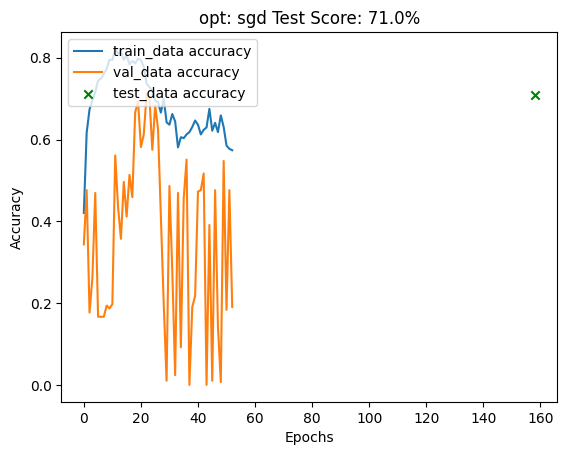

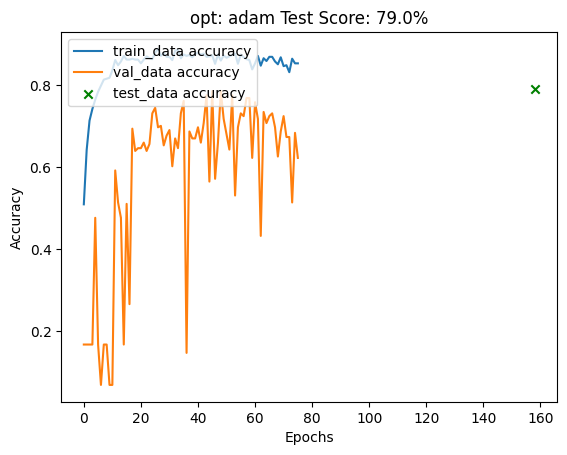

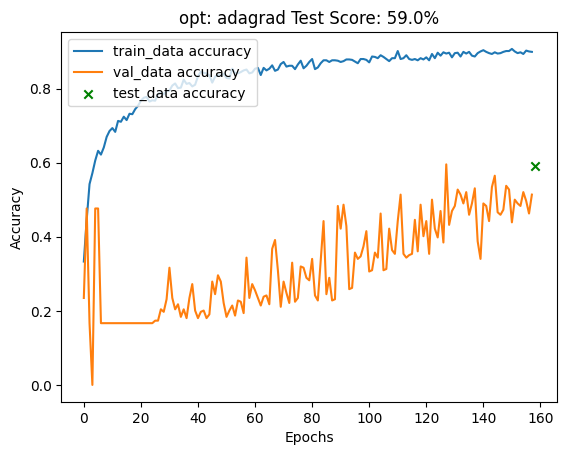

In [8]:
number_of_epochs = len(history.history["accuracy"])
for history_with_param in histories_with_params:
    model = load_model(f"cnn_files/model_{history_with_param['optimizer']}.keras")
    test_score = round(model.evaluate(X_test, y_test)[1], 2)*100
    del model
    gc.collect()

    plt.figure()
    plt.plot(history_with_param["history"].history["accuracy"], label="train_data accuracy")
    plt.plot(history_with_param["history"].history["val_accuracy"], label="val_data accuracy")
    plt.scatter(number_of_epochs, test_score/100, label="test_data accuracy", marker="x", c="g")
    plt.title(f"opt: {history_with_param['optimizer']} Test Score: {test_score}%")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")
    plt.savefig(f"./cnn_files/{history_with_param['optimizer']}.png",dpi=600)
    #plt.show()


In [9]:
print(y_test.shape)

batch_sizes = [8, 16, 32, 64, 128]
learning_rates = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
conv_kernel_sizes = [[(3,3), (3, 3)],[(7,7), (3, 3)],[(11,11), (3, 3)]] # schauen, ob ggf. wir mehr layer benutzen
conv_filter_nums = [[32,32],[32, 64],[64,64],[64,32]]
number_of_neurons = [[256, 128, 64]]
histories_with_params = list()

test_list = product(batch_sizes, learning_rates, conv_kernel_sizes, conv_filter_nums, number_of_neurons)
print(f"Trying out {len(test_list)} different combination.")
# do again cause list
test_list = product(batch_sizes, learning_rates, conv_kernel_sizes, conv_filter_nums, number_of_neurons)

for batch_size, learning_rate, conv_kernel_size, conv_filter_num, number_of_neuron in test_list:
    print(f"Now training model with bs={batch_size}, ls={learning_rate}, kn={conv_kernel_size[0]}x{conv_kernel_size[1]}, ft={conv_filter_num[0]}x{conv_filter_num[1]}, nn={number_of_neuron[0]}x{number_of_neuron[1]}x{number_of_neuron[2]}")
    model = create_model(conv_kernel_size, conv_filter_num,number_of_neuron)
    #model.summary()
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        #workers=8, # workers are number of cores
        callbacks=[early_stopping,ClearMemory()],
        validation_data=(X_val, y_val),
        verbose=1)
    
    #parameters = {
    #    "bs": batch_size, 
    #    "lr": learning_rate,
    #    "kn": conv_kernel_size,
    #    "ft": conv_filter_num,
    #    "nn": number_of_neuron,
    #    "ts": round(model.evaluate(X_test, y_test)[1], 2)*100
    #}
    
    #history_with_param = {"history": history, "parameters": parameters}
    #
    #histories_with_params.append(history_with_param)
    # too clear cache?
    model.save(f'./t/a.keras',overwrite=True)

    #print(f"Epochs: {len(history.history['accuracy'])}")
    #print(f"Test Score: {round(model.evaluate(X_test, y_test)[1], 2)}%")
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()
    del model
    gc.collect()
    #reset_keras()


(294,)
Trying out 300 different combination.
Now training model with bs=8, ls=0.01, kn=(3, 3)x(3, 3), ft=32x32, nn=256x128x64
Epoch 1/200
110/110 [==============================] - 7s 53ms/step - loss: 4.1446 - accuracy: 0.3920 - f1_score: 0.3663 - val_loss: 1.3092 - val_accuracy: 0.4762 - val_f1_score: 0.3664
Epoch 2/200
110/110 [==============================] - 6s 50ms/step - loss: 1.2316 - accuracy: 0.4398 - f1_score: 0.3663 - val_loss: 1.2161 - val_accuracy: 0.4762 - val_f1_score: 0.3664
Epoch 3/200
110/110 [==============================] - 6s 50ms/step - loss: 1.1491 - accuracy: 0.4625 - f1_score: 0.3663 - val_loss: 1.1661 - val_accuracy: 0.4762 - val_f1_score: 0.3664
Epoch 4/200
110/110 [==============================] - 6s 51ms/step - loss: 1.5332 - accuracy: 0.4307 - f1_score: 0.3663 - val_loss: 1.1643 - val_accuracy: 0.4762 - val_f1_score: 0.3664
Epoch 5/200
110/110 [==============================] - 6s 50ms/step - loss: 3.5557 - accuracy: 0.4284 - f1_score: 0.3663 - val_los

KeyboardInterrupt: 

In [ ]:
#number_of_epochs = len(history.history["accuracy"])

#for history_with_param in histories_with_params:
    #model = load_model(f"./cnn_files/cnn_bs{
    #    history_with_param['parameters']['bs']
    #    }_ls{
    #    history_with_param['parameters']['lr']
    #    }_kn{
    #    history_with_param['parameters']['kn'][0]
    #    }x{
    #    history_with_param['parameters']['kn'][1]
    #    }_ft{
    #    history_with_param['parameters']['ft'][0]
    #    }x{
    #    history_with_param['parameters']['ft'][1]
    #    }_nn{
    #    history_with_param['parameters']['nn'][0]
    #    }x{
    #    history_with_param['parameters']['nn'][1]
    #    }x{
    #    history_with_param['parameters']['nn'][2]
    #    }.keras")
    
#    plt.plot(history_with_param["history"].history["val_accuracy"], label="val_data accuracy")
#    plt.plot(history_with_param["history"].history["accuracy"], label="train_data accuracy")
#    
#    plt.scatter(number_of_epochs, model.evaluate(X_test, y_test)[1], label="test_data accuracy", marker="x", c="g")
#    plt.title(f"bs{
#        history_with_param['parameters']['bs']
##        } ls{
#        history_with_param['parameters']['lr']
#        }\nkn{
#        history_with_param['parameters']['kn'][0]
#        }x{
#        history_with_param['parameters']['kn'][1]
#        } ft{
#        history_with_param['parameters']['ft'][0]
#        }x{
 #       history_with_param['parameters']['ft'][1]
 ##       }\nnn{
 #       history_with_param['parameters']['nn'][0]
 #       }x{
  #      history_with_param['parameters']['nn'][1]
#        }x{
#        history_with_param['parameters']['nn'][2]
#        }\nts{
#        history_with_param['parameters']['ts']
#        }")
#    plt.xlabel("Epochs")
#    plt.ylabel("Accuracy")
#    plt.legend(loc="lower right")
#    plt.savefig(f"./cnn_files/cnn_bs{
#        history_with_param['parameters']['bs']
#        }_ls{
#        history_with_param['parameters']['lr']
#        }_kn{
#        history_with_param['parameters']['kn'][0]
#        }x{
##        history_with_param['parameters']['kn'][1]
#        }_ft{
##        history_with_param['parameters']['ft'][0]
#        }x{
#        history_with_param['parameters']['ft'][1]
#        }_nn{
#        history_with_param['parameters']['nn'][0]
#        }x{
 #       history_with_param['parameters']['nn'][1]
 #       }x{
#       history_with_param['parameters']['nn'][2]
#        }.keras",dpi=200)
#    plt.show()



In [ ]:
# prints n=|base_group| figures with subplots, based on the other paramters
def print_results(base_group: (str,list), histories_all: list, number_of_epochs: int) -> None:
    # for everx value of base group create figure, and than create subplots based on how many paramters there are
    for val in base_group[1]:
        # get all histires with said value
        histories = [his for his in histories_all if his['parameters'][base_group[0]]==val]    
        # Compute Rows required
        total = len(base_group[1])
        cols = int((total)**0.5)
        rows = total // cols
        if total % cols != 0:
            rows += 1
        pos = range(1,total+1)
        
        # plot
        fig = plt.figure(figsize=(15,10))
        for i in range(0,len(histories)):
            # load model
            model = load_model(f"./cnn_files/cnn_bs{histories[i]['parameters']['bs']}_ls{histories[i]['parameters']['lr']}.keras")
            # get test score
            test_score = round(model.evaluate(X_test, y_test)[1], 2)*100
            # make a new subplot for every history
            ax = fig.add_subplot(rows,cols,pos[i])
            ax.set_ylim([0,1])
            ax.set_xlim([0,number_of_epochs])
            ax.plot(histories[i]["history"].history["val_accuracy"], label="val_data accuracy")
            ax.plot(histories[i]["history"].history["accuracy"], label="train_data accuracy")
            ax.set_title(f"{base_group[0]}: {histories[i]['parameters'][base_group[0]]} lr: {histories[i]['parameters']['lr']}, Test Score: {test_score}%")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Accuracy")
            ax.legend(loc="lower right")
        plt.savefig(f"t/{val}_a.png")        
        plt.show()
        plt.close()

print_results(('bs',batch_sizes),histories_with_params,150)

In [ ]:
#tf.keras.backend.clear_session()
#gc.collect()

In [ ]:
# get memory usage

import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted_vars = sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

sorted_vars_in_gb = [(var, size / (1024 ** 3)) for var, size in sorted_vars]
sorted_vars_in_gb
total_memory = sum(size for _, size in sorted_vars)
total_memory_in_gb = total_memory / (1024 ** 3)
total_memory_in_gb